In [1]:
import keras
from keras.layers import *
from keras.models import Model
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
INPUT_SHAPE = (128,128,3)
NOISE_DIM = 100

# 1.DATA

### Loading the Dataset

In [ ]:
(ds_train, ds_test, ds_val), info = tfds.load('oxford_flowers102', split=['test', 'train', 'validation'], with_info=True)

Adding validation data to training data

In [4]:
ds_train = ds_train.concatenate(ds_val)

### Processing the Dataset

In [5]:
def process(data):
    return (tf.image.resize(data['image'], (INPUT_SHAPE[0], INPUT_SHAPE[1]))-127.5)/127.5

train = ds_train.map(process)
test = ds_test.map(process)

In [6]:
train = train.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
train, test

(<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>,
 <_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>)

In [8]:
len(train), len(test)

(225, 32)

### Testing the Dataset

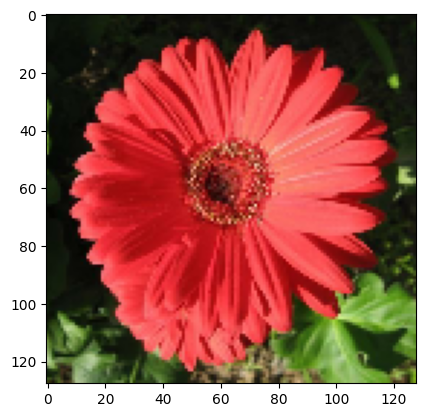

In [9]:
plt.imshow(tf.cast(train.as_numpy_iterator().next()[0]*127.5+127.5,dtype=tf.uint8))

# 2.MODEL

### Building the Model

In [10]:
class DCGAN(Model):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.noise_dim = (NOISE_DIM,)
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()


    # Builds the generator
    def build_generator(self):
        input = Input(shape=self.noise_dim)

        # Project and reshape
        x = Dense(8 * 8 * 1024)(input)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Reshape((8, 8, 1024))(x)

        # Upsamplings
        x = Conv2DTranspose(512, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2DTranspose(256, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2DTranspose(128, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        # Output
        out = Conv2DTranspose(3, 5, (2,2), padding="same", activation='tanh', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)

        return Model(inputs=input, outputs=out)


    # Builds the discriminator
    def build_discriminator(self):
        input = Input(shape=INPUT_SHAPE)

        # Convolutions
        x = Conv2D(128, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(input)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(256, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(512, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(1024, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        # Output
        x = Flatten()(x)
        out = Dense(1, activation='sigmoid')(x)

        return Model(inputs=input, outputs=out)


    def compile(self, disc_opt_func, gen_opt_func, disc_loss_func, gen_loss_func):
        super().compile()
        self.disc_opt = disc_opt_func
        self.gen_opt = gen_opt_func
        self.disc_loss = disc_loss_func
        self.gen_loss = gen_loss_func


    # Custom train
    def train_step(self, data):
        noise = tf.random.uniform((BATCH_SIZE,NOISE_DIM,))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.gen_loss(fake_output)
            disc_loss = self.disc_loss(real_output, fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.disc_opt.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        return {"total_loss":gen_loss + disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Custom test
    def test_step(self, data):
        noise = tf.random.uniform((BATCH_SIZE,NOISE_DIM,))

        generated_images = self.generator(noise, training=False)

        real_output = self.discriminator(data, training=False)
        fake_output = self.discriminator(generated_images, training=False)

        gen_loss = self.gen_loss(fake_output)
        disc_loss = self.disc_loss(real_output, fake_output)

        return {"total_loss":gen_loss + disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    def save(self, file_path):
        self.generator.save(file_path)


    def call(self, inputs):
        return self.generator(inputs)

In [11]:
model = DCGAN()

### Optimizer and Loss Functions

In [12]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def disc_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake), fake)

In [13]:
model.compile(disc_opt, gen_opt, disc_loss, gen_loss)

### Training the Model

In [ ]:
model.fit(train, epochs=150, validation_data=test)

### Testing the Model

#### Original Images

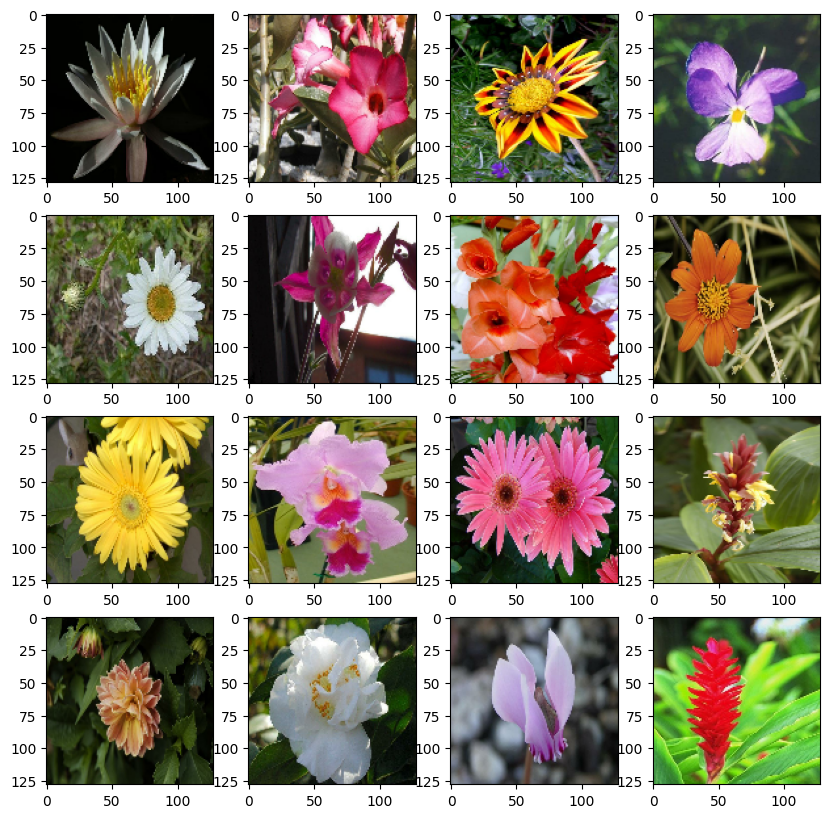

In [15]:
samples = test.as_numpy_iterator().next()

fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(tf.cast(samples[i*4+j]*127.5+127.5, dtype=tf.uint8))

#### Generated Images

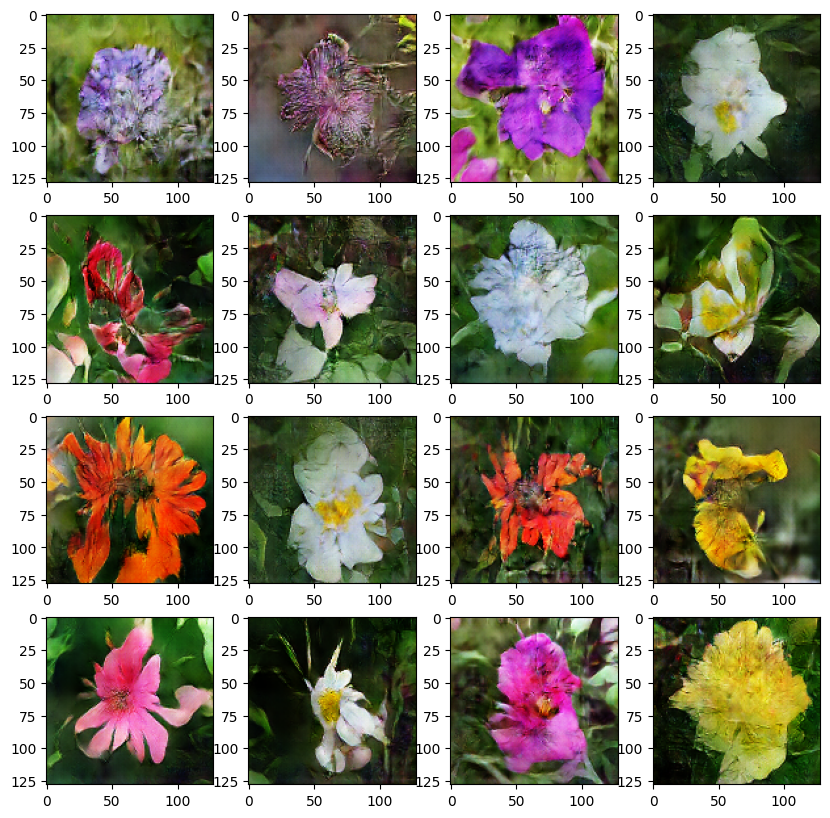

In [51]:
noise = tf.random.uniform((16,NOISE_DIM,))
images = model(noise)

fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(tf.cast(images[i*4+j]*127.5+127.5, dtype=tf.uint8))

### Saving the Model

In [ ]:
model.save('DCGAN.h5')